# Import Useful Modules 

In [1]:
# import tensorflow
# config = tensorflow.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5 #(misalnya kalo pengen 0.4 dari GPU memory)
# session = tensorflow.Session(config=config)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import gmtime, strftime
import time
import datetime
from collections import Counter
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Embedder
from gensim.models import FastText


# # Classifier
from xgboost import XGBClassifier as XGB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.grid_search import GridSearchCV as GS
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures as Poly

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.preprocessing import sequence
np.random.seed(7)

In [7]:
#Determine Model's File Location

version = "Fixed"

# ---------------------------------------------------------------------------------------------------------------

# Import Model

In [9]:
from preprocessing_pipeline import preprocessing

with open("model/{}/word_embedder_100.pickle".format(version), "rb") as file:
    word_embedder = pickle.load(file)

## Check

#### Preprocessing

In [10]:
preprocessor=preprocessing(word_embedder.vector_size,word_embedder)
preprocessor

#### Word Embedding

In [11]:
word_embedder

# ---------------------------------------------------------------------------------------------------------------

# Read Data To Pandas Dataframe

In [3]:
large_data_for_classification=pd.read_csv("data/query.csv",header=None)
large_data_for_classification.dropna(axis=0,inplace=True)

In [4]:
large_data_for_classification.head()

,0,1,2
0,hunting,gear+camping,327
1,koleksi,Lightstick+EXO,63
2,kartu-perdana,vivo+v7,183
3,aksesoris-mobil,subwoofer+kolong+aktif,389
4,anak-perempuan,Hotpants+anak,1366


### Preprocess Data

In [10]:
raw_category_mapper=pd.read_csv("raw_leaf.csv",index_col=0)

category_mapper={}
for i in raw_category_mapper.index:
    category_mapper[raw_category_mapper["l2"][i]]=raw_category_mapper["l1"][i]

In [11]:
new_category=[category_mapper[value] for value in large_data_for_classification[0]]
large_data_for_classification[0]=new_category

In [16]:
large_data_for_classification[0].head()

0            hunting
1            koleksi
2      kartu-perdana
3    aksesoris-mobil
4     anak-perempuan
Name: 0, dtype: object

In [ ]:
#preprocess product title to 100-dimensional vector
#and preprocess category name to integer label
large_embedded_data, large_label_encoder = preprocessor.preprocess_data(
    large_data_for_classification[1],
    large_data_for_classification[0],
)

  0%|          | 1/2440682 [00:00<306:22:30,  2.21it/s]

REMOVING PUNCTUATIONS


  0%|          | 4796/2440682 [00:01<13:17, 3053.57it/s]

In [ ]:
large_embedded_data.head()
large_embedded_data["sum"]=large_embedded_data.drop(["Labels"],axis=1).sum(axis=1)
large_embedded_data=large_embedded_data.loc[large_embedded_data["sum"]!=0].drop("sum",axis=1)

In [ ]:
large_embedded_data.shape

In [ ]:
large_label_encoder

# ---------------------------------------------------------------------------------------------------------------

# Neural Network

In [ ]:
data=large_embedded_data
sampled_embedded_data=data.sample(n=len(data))

In [ ]:
nn_X_train,nn_X_test,nn_y_train,nn_y_test=train_test_split(sampled_embedded_data.drop("Labels",axis=1),to_categorical(sampled_embedded_data["Labels"]),test_size=0.1)

In [ ]:
def accuracy(predicted,truth):
    result=[int(value) for value in np.array(predicted)==np.array(truth)]
    return sum(result)/len(result)

In [ ]:
model = Sequential()
model.add(Dense(600, input_shape=(300,), activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(232, activation='softmax'))


model.compile(optimizer="Adagrad", loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(nn_X_train, nn_y_train, epochs=10, batch_size=100, validation_data=(nn_X_test,nn_y_test), shuffle=True)

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
model.save("nn_experiment_90.h5")

# ---------------------------------------------------------------------------------------------------------------

# Splitting Data For Other Model

In [18]:
data=large_embedded_data
sampled_embedded_data=data.sample(n=len(data))

In [19]:
X_train,X_test,y_train,y_test=train_test_split(sampled_embedded_data.drop("Labels",axis=1), sampled_embedded_data["Labels"],test_size=0.2)

# ---------------------------------------------------------------------------------------------------------------

# Logistic Regression

In [ ]:
print("Start Time : {}\n".format(str(datetime.datetime.now())))
baseline_lr=LR(n_jobs=-1,solver="saga")
baseline_lr.fit(X_train,y_train)
print("Finish Time : {}\n".format(str(datetime.datetime.now())))

In [ ]:
with open('lr_new','wb') as f:
    pickle.dump(baseline_lr,f)

# ---------------------------------------------------------------------------------------------------------------

# Support Vector Machine

In [ ]:
print("Start Time : {}\n".format(str(datetime.datetime.now())))
baseline_svm = SVC(verbose=4)
baseline_svm.fit(X_train,y_train)
svm_pred=baseline_svm.predict(X_test)
svm_truth=y_test
print("Finish Time : {}\n".format(str(datetime.datetime.now())))
print(classification_report(svm_pred,svm_truth))

Start Time : 2018-07-19 07:41:39.726667

[LibSVM]

In [ ]:
with open('svm_model','wb') as f:
    pickle.dump(baseline_svm,f)

1


# ---------------------------------------------------------------------------------------------------------------

# XGBoost

In [33]:
print("Start Time : {}\n".format(str(datetime.datetime.now())))
baseline_xgb_big=XGB(n_jobs=16,max_depth=6,n_estimators=1000,silent=True,objective="multi:softmax")
baseline_xgb_big.fit(X_train,y_train)
base_truth_xgb_big=y_test
pred_xgb_big=baseline_xgb_big.predict(X_test)
print("Finish Time : {}\n".format(str(datetime.datetime.now())))

Start Time : 2018-07-18 10:52:27.461172

Finish Time : 2018-07-18 11:06:38.915193



In [35]:
with open('xgb_new.pickle','wb') as f:
    pickle.dump(baseline_xgb_big,f)

             precision    recall  f1-score   support

          0       0.57      0.51      0.54      3884
          1       0.77      0.46      0.57       862
          2       0.67      0.82      0.74      9564
          3       0.77      0.58      0.66      4850
          4       0.71      0.34      0.46       748
          5       0.84      0.90      0.87     10524
          6       0.58      0.75      0.66      9230
          7       0.51      0.25      0.34      1423
          8       0.84      0.74      0.79      2475
          9       0.68      0.36      0.47      1201
         10       0.79      0.77      0.78      5408
         11       0.77      0.63      0.69      3388
         12       0.82      0.87      0.85      8504
         13       0.76      0.60      0.67      5555
         14       0.74      0.60      0.66      1388
         15       0.84      0.47      0.60       749
         16       0.70      0.20      0.31       636
         17       0.58      0.68      0.62   

# ---------------------------------------------------------------------------------------------------------------

In [13]:
dd=preprocessor.class_count(large_data_for_classification[0])

[1,
 2,
 2,
 4,
 5,
 9,
 37,
 55,
 104,
 104,
 111,
 116,
 126,
 143,
 150,
 153,
 214,
 238,
 262,
 279,
 295,
 314,
 392,
 416,
 457,
 473,
 514,
 531,
 533,
 533,
 541,
 543,
 564,
 602,
 602,
 605,
 653,
 656,
 664,
 685,
 690,
 693,
 694,
 698,
 714,
 733,
 754,
 776,
 777,
 803,
 808,
 833,
 867,
 891,
 903,
 943,
 974,
 1012,
 1016,
 1036,
 1112,
 1157,
 1159,
 1168,
 1173,
 1217,
 1303,
 1307,
 1471,
 1502,
 1535,
 1544,
 1546,
 1551,
 1560,
 1621,
 1634,
 1655,
 1774,
 1783,
 1862,
 1873,
 1908,
 1934,
 2050,
 2102,
 2218,
 2270,
 2292,
 2330,
 2335,
 2342,
 2368,
 2382,
 2405,
 2426,
 2457,
 2467,
 2483,
 2513,
 2665,
 2737,
 2746,
 2781,
 2798,
 2855,
 2864,
 2936,
 3027,
 3170,
 3242,
 3356,
 3472,
 3506,
 3510,
 3530,
 3814,
 3874,
 4186,
 4300,
 4441,
 4619,
 4625,
 4703,
 4777,
 4854,
 4912,
 5017,
 5290,
 5310,
 5310,
 5382,
 5687,
 5766,
 5837,
 5923,
 5952,
 5972,
 6079,
 6165,
 6184,
 6188,
 6234,
 6249,
 6252,
 6329,
 6451,
 6668,
 6886,
 7197,
 7323,
 7480,
 7532,


['men-s-grooming',
 'mobil',
 'men-s-perfume',
 'jersey',
 'personal-care-lainnya',
 'women-s-perfume',
 'makanan-minuman',
 'motor',
 'produk-kesehatan',
 'furniture',
 'polo-shirt-1099',
 'kesehatan-wanita',
 'nutrition-energy',
 'ikat-pinggang',
 'piyama-baju-tidur-2657',
 'produk-kecantikan',
 'kesehatan-mata',
 'sarung-tangan-935',
 'kesehatan-telinga',
 'sendal-294',
 'remote-trigger',
 'bikini',
 'perawatan-tubuh',
 'kaus-kaki-1116',
 'strap',
 'softlens',
 'charger',
 'hood-cap',
 'payung',
 'memory-card-194',
 'scanner',
 'roller-skate',
 'bouncer-chair',
 'legging-stocking',
 'kaus-kaki',
 'topi-1096',
 'perlengkapan-mandi',
 'handycam',
 'kesehatan-mulut-gigi',
 'sarung-tangan',
 'filter',
 'jumpsuit',
 'voice-recorder',
 'cd-vcd-dvd-blu-ray-player',
 'baby-carrier',
 'skateboard',
 'makanan-711',
 'baju-hamil',
 'virtual-reality',
 'sparepart-kamera',
 'jeans-1093',
 'flash',
 'travel-hiburan',
 'converter-adapter',
 'dairy-products',
 'perlengkapan-makan',
 'pelangsing',
 

In [19]:
fffff=list(dd)
lllll=[dd[val] for val in fffff]

In [33]:
sorted(dd.values())

[1,
 2,
 2,
 4,
 5,
 9,
 37,
 55,
 104,
 104,
 111,
 116,
 126,
 143,
 150,
 153,
 214,
 238,
 262,
 279,
 295,
 314,
 392,
 416,
 457,
 473,
 514,
 531,
 533,
 533,
 541,
 543,
 564,
 602,
 602,
 605,
 653,
 656,
 664,
 685,
 690,
 693,
 694,
 698,
 714,
 733,
 754,
 776,
 777,
 803,
 808,
 833,
 867,
 891,
 903,
 943,
 974,
 1012,
 1016,
 1036,
 1112,
 1157,
 1159,
 1168,
 1173,
 1217,
 1303,
 1307,
 1471,
 1502,
 1535,
 1544,
 1546,
 1551,
 1560,
 1621,
 1634,
 1655,
 1774,
 1783,
 1862,
 1873,
 1908,
 1934,
 2050,
 2102,
 2218,
 2270,
 2292,
 2330,
 2335,
 2342,
 2368,
 2382,
 2405,
 2426,
 2457,
 2467,
 2483,
 2513,
 2665,
 2737,
 2746,
 2781,
 2798,
 2855,
 2864,
 2936,
 3027,
 3170,
 3242,
 3356,
 3472,
 3506,
 3510,
 3530,
 3814,
 3874,
 4186,
 4300,
 4441,
 4619,
 4625,
 4703,
 4777,
 4854,
 4912,
 5017,
 5290,
 5310,
 5310,
 5382,
 5687,
 5766,
 5837,
 5923,
 5952,
 5972,
 6079,
 6165,
 6184,
 6188,
 6234,
 6249,
 6252,
 6329,
 6451,
 6668,
 6886,
 7197,
 7323,
 7480,
 7532,


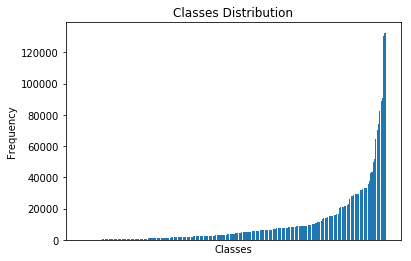

In [60]:
plt.bar(range(len(sorted(dd, key=dd.get))),sorted(dd.values()))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel("Frequency")
plt.xlabel("Classes")
plt.title("Classes Distribution")
plt.show()

In [53]:
a=pd.DataFrame()
a["Top 5 Level 2 Category"]=["Smartphone","Sparepart Motor","Aksesoris Handphone","Aksesoris Motor","Mainan"]

In [54]:
sorted(dd, key=dd.get)

['men-s-grooming',
 'mobil',
 'men-s-perfume',
 'jersey',
 'personal-care-lainnya',
 'women-s-perfume',
 'makanan-minuman',
 'motor',
 'produk-kesehatan',
 'furniture',
 'polo-shirt-1099',
 'kesehatan-wanita',
 'nutrition-energy',
 'ikat-pinggang',
 'piyama-baju-tidur-2657',
 'produk-kecantikan',
 'kesehatan-mata',
 'sarung-tangan-935',
 'kesehatan-telinga',
 'sendal-294',
 'remote-trigger',
 'bikini',
 'perawatan-tubuh',
 'kaus-kaki-1116',
 'strap',
 'softlens',
 'charger',
 'hood-cap',
 'payung',
 'memory-card-194',
 'scanner',
 'roller-skate',
 'bouncer-chair',
 'legging-stocking',
 'kaus-kaki',
 'topi-1096',
 'perlengkapan-mandi',
 'handycam',
 'kesehatan-mulut-gigi',
 'sarung-tangan',
 'filter',
 'jumpsuit',
 'voice-recorder',
 'cd-vcd-dvd-blu-ray-player',
 'baby-carrier',
 'skateboard',
 'makanan-711',
 'baju-hamil',
 'virtual-reality',
 'sparepart-kamera',
 'jeans-1093',
 'flash',
 'travel-hiburan',
 'converter-adapter',
 'dairy-products',
 'perlengkapan-makan',
 'pelangsing',
 

In [55]:
a

,Top 5 Level 2 Category
0,Smartphone
1,Sparepart Motor
2,Aksesoris Handphone
3,Aksesoris Motor
4,Mainan


In [58]:
a=pd.DataFrame()
a["Bottom 5 Classes"]=["Men's Grooming","Mobil","Men's Perfume","Jersey","Personal Care Lainnya"]
a["Top 5 Classes"]=["Smartphone","Sparepart Motor","Aksesoris Handphone","Aksesoris Motor","Mainan"]

In [59]:
a

,Bottom 5 Classes,Top 5 Classes
0,Men's Grooming,Smartphone
1,Mobil,Sparepart Motor
2,Men's Perfume,Aksesoris Handphone
3,Jersey,Aksesoris Motor
4,Personal Care Lainnya,Mainan
